# b2metric case study
This is Fırat Kızılboğa's Case Study.

I will start by manipulating the data
https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction i will use this as a starting point

In [1]:
!pip install catboost
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00


In [5]:
!pip install kaggle
!mkdir ~/.kaggle
!cd /content
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-credit-default-risk
!unzip home-credit-default-risk.zip -d data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 673M/688M [00:03<00:00, 186MB/s]
100% 688M/688M [00:03<00:00, 213MB/s]
Archive:  home-credit-default-risk.zip
  inflating: data/HomeCredit_columns_description.csv  
  inflating: data/POS_CASH_balance.csv  
  inflating: data/application_test.csv  
  inflating: data/application_train.csv  
  inflating: data/bureau.csv         
  inflating: data/bureau_balance.csv  
  inflating: data/credit_card_balance.csv  
  inflating: data/installments_payments.csv  
  inflating: data/previous_application.csv  
  inflating: data/sample_submission.csv  


In [6]:
app_test = pd.read_csv('/content/data/application_test.csv', encoding='latin-1')
app_train = pd.read_csv('/content/data/application_train.csv', encoding='latin-1')

In [7]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [8]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [9]:
TARGET = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = TARGET

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [10]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5, 0, 'Days Employment')

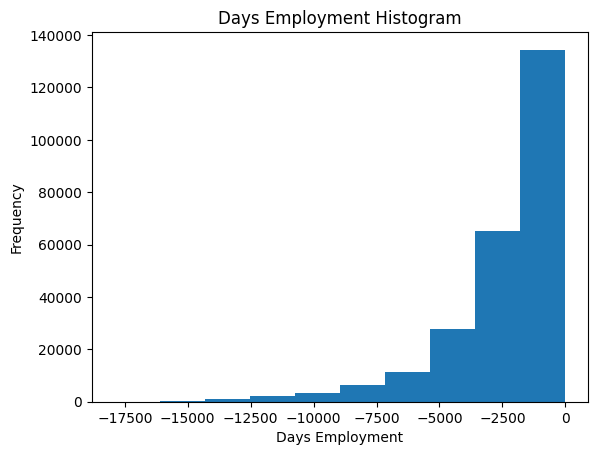

In [11]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [12]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [13]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,-25.920548,NaN
1,0,-16765,-45.931507,NaN
2,0,-19046,-52.180822,NaN
3,0,-19005,-52.068493,NaN
4,0,-19932,-54.608219,NaN
5,0,-16941,-46.413699,NaN
6,0,-13778,-37.747945,NaN
7,0,-18850,-51.643836,NaN
8,0,-20099,-55.065753,NaN
9,0,-14469,-39.641096,NaN


In [14]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",NaN,NaN,NaN
"(25.0, 30.0]",NaN,NaN,NaN
"(30.0, 35.0]",NaN,NaN,NaN
"(35.0, 40.0]",NaN,NaN,NaN
"(40.0, 45.0]",NaN,NaN,NaN
"(45.0, 50.0]",NaN,NaN,NaN
"(50.0, 55.0]",NaN,NaN,NaN
"(55.0, 60.0]",NaN,NaN,NaN
"(60.0, 65.0]",NaN,NaN,NaN


In [15]:
del anom, age_data, age_groups, non_anom, le, le_count, col

## Catboost

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

In [13]:
!pip install catboost lofo-importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Base Case

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier(iterations=100, random_state=50, verbose=1)

# Fit the CatBoost classifier on the training data
catboost.fit(train, TARGET)

# Extract feature importances
feature_importance_values = catboost.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = catboost.predict_proba(test)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost.csv', index=False)

Learning rate set to 0.5
0:	learn: 0.3453151	total: 207ms	remaining: 20.5s
1:	learn: 0.2778456	total: 369ms	remaining: 18.1s
2:	learn: 0.2619763	total: 523ms	remaining: 16.9s
3:	learn: 0.2566431	total: 678ms	remaining: 16.3s
4:	learn: 0.2537030	total: 864ms	remaining: 16.4s
5:	learn: 0.2523237	total: 1.05s	remaining: 16.4s
6:	learn: 0.2509554	total: 1.22s	remaining: 16.3s
7:	learn: 0.2500914	total: 1.39s	remaining: 16s
8:	learn: 0.2496016	total: 1.53s	remaining: 15.5s
9:	learn: 0.2488576	total: 1.7s	remaining: 15.3s
10:	learn: 0.2485006	total: 1.84s	remaining: 14.9s
11:	learn: 0.2479892	total: 1.99s	remaining: 14.6s
12:	learn: 0.2478194	total: 2.26s	remaining: 15.1s
13:	learn: 0.2475339	total: 2.46s	remaining: 15.1s
14:	learn: 0.2473207	total: 2.59s	remaining: 14.7s
15:	learn: 0.2470972	total: 2.84s	remaining: 14.9s
16:	learn: 0.2465424	total: 3.17s	remaining: 15.5s
17:	learn: 0.2463218	total: 3.56s	remaining: 16.2s
18:	learn: 0.2462125	total: 3.84s	remaining: 16.4s
19:	learn: 0.246070

Private / Public
0.74016 0.74397

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

I will use Stratified KFold data is imbalanced

### LOFO Importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/240 [00:00<?, ?it/s]

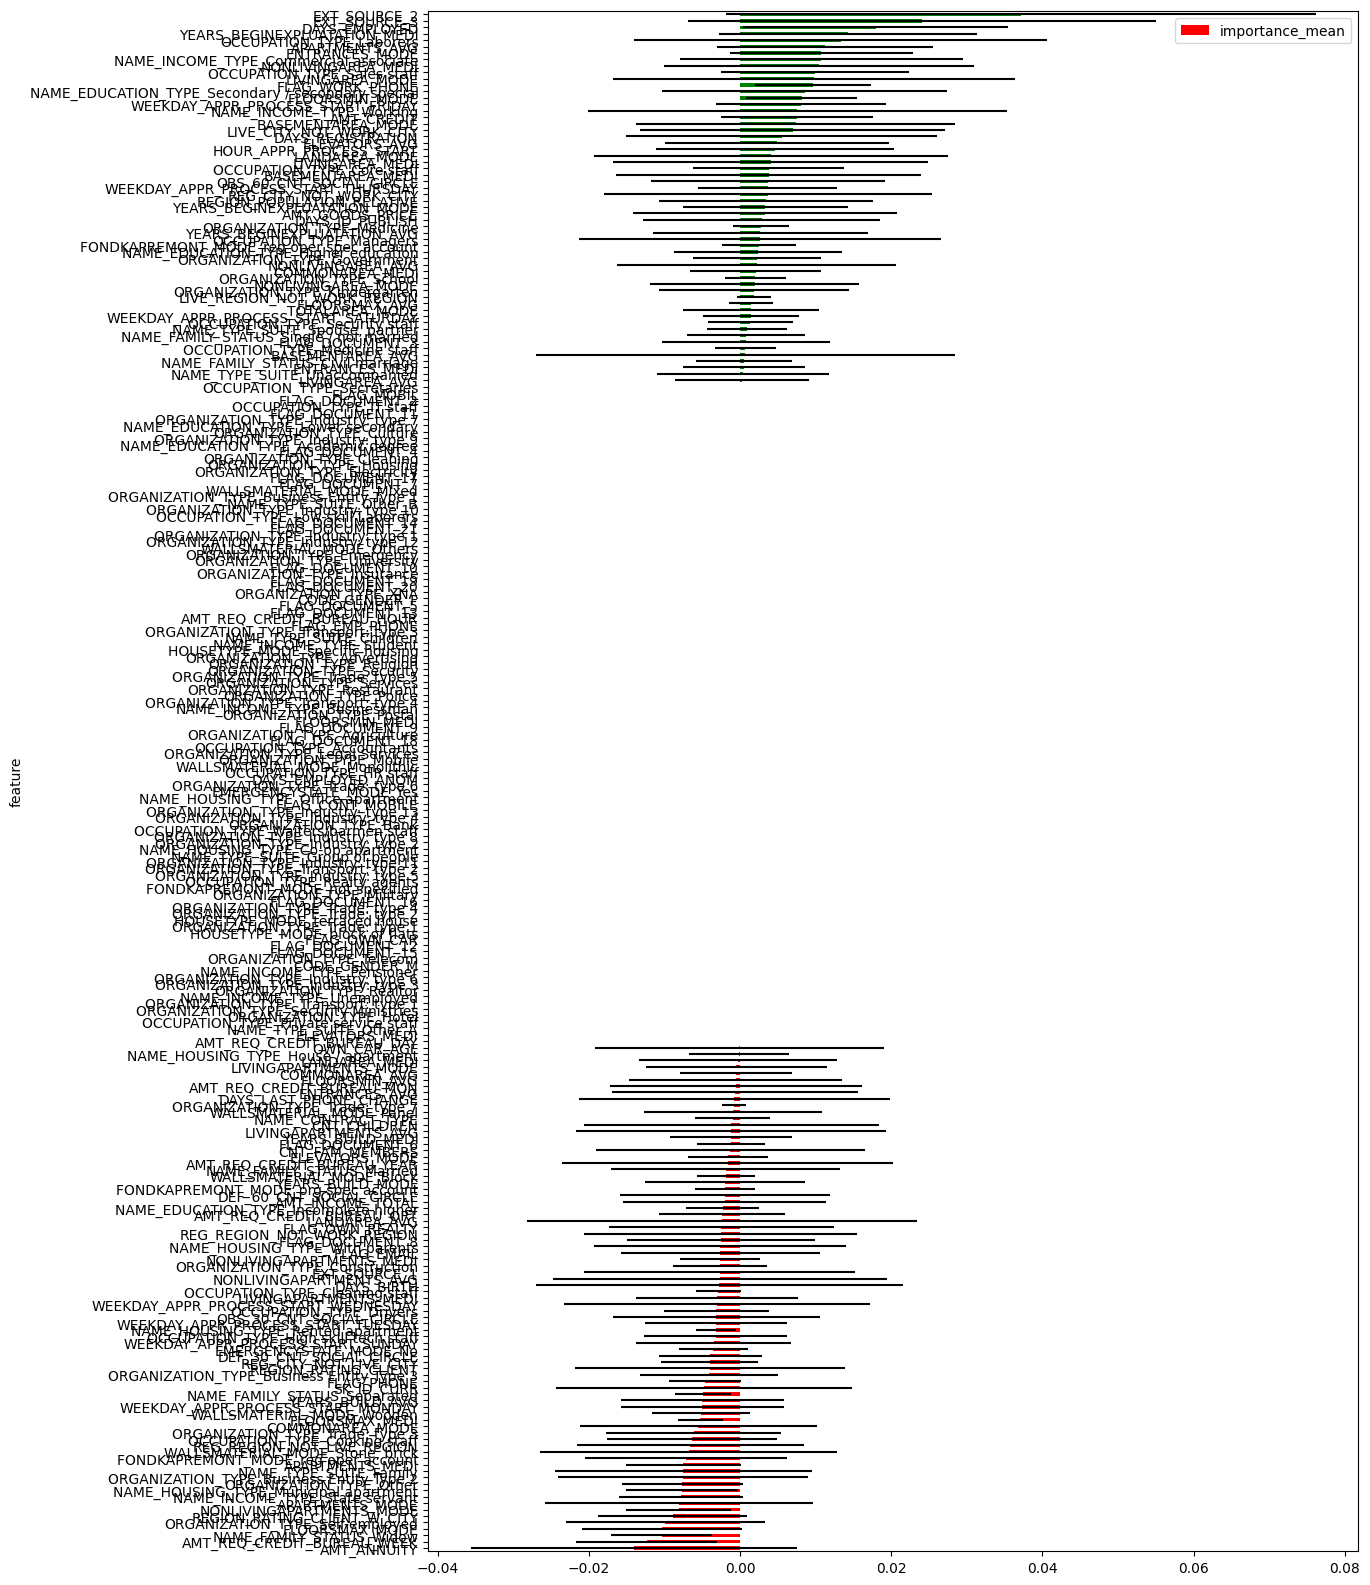

In [17]:
!pip install lofo-importance
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

catboost = CatBoostClassifier(iterations=100, random_state=50, verbose=0)
# extract a sample of the data
sample_df = app_train.sample(frac=0.01, random_state=0)

# define the validation scheme
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define the binary target and the features
dataset = Dataset(df=sample_df, target="TARGET", features=[col for col in app_train.columns if col != "TARGET"])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=stratified_kfold, scoring="roc_auc", model=None)

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [ ]:
good_features = importance_df[importance_df.importance_mean > 0].feature.tolist()
TRAIN_DF = app_train[good_features]
TARGET = app_train['TARGET']

### Hyperparameter Optimization

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'random_strength': trial.suggest_int('random_strength', 1, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
        }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    clf = CatBoostClassifier(**params, verbose=False)

    cv_results = cross_val_score(clf, TRAIN_DF.values, TARGET.values, cv=cv, n_jobs=-1, scoring='roc_auc')
    score = np.mean(cv_results)

    return score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100, timeout=600)

In [ ]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=3)

[I 2023-06-24 09:23:40,618] A new study created in memory with name: no-name-6275f526-7117-47da-9811-7597b0fbb2e4
[I 2023-06-24 09:29:06,447] Trial 0 finished with value: 0.7200224703787207 and parameters: {'iterations': 777, 'depth': 6, 'learning_rate': 0.006884812806623497, 'random_strength': 70, 'bagging_temperature': 0.4450572480096512, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 0 with value: 0.7200224703787207.
[I 2023-06-24 09:31:07,281] Trial 1 finished with value: 0.674173169987544 and parameters: {'iterations': 299, 'depth': 4, 'learning_rate': 0.006743154436121284, 'random_strength': 98, 'bagging_temperature': 15.72465987067448, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 0 with value: 0.7200224703787207.
[I 2023-06-24 09:32:35,159] Trial 2 finished with value: 0.6718998390453861 and parameters: {'iterations': 129, 'depth': 7, 'learning_rate': 0.007454780281089917, 'random_strength': 88, 'bagging_temperature': 70.1294543207869, 'od_type': 'IncToDec', 'od_wa

In [ ]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(TRAIN_DF.values, TARGET.values)
y_prob = clf.predict_proba(app_test[TRAIN_DF.columns.tolist()])
y_prob[:, 1]
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': y_prob[:, 1]})
df.to_csv('/content/catboost.csv', index=False)

~0.71 accuracy

I will change the area that we are searching in

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 1, 16),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.5),
        'random_strength': trial.suggest_int('random_strength', 1, 30),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100),
        }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    clf = CatBoostClassifier(**params, verbose=True)

    cv_results = cross_val_score(clf, TRAIN_DF.values, TARGET.values, cv=cv, n_jobs=-1, scoring='roc_auc', error_score='raise')
    score = np.mean(cv_results)

    return score
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100, timeout=600)

[I 2023-06-24 13:02:19,288] A new study created in memory with name: no-name-e7983ff4-2237-4a4f-9540-5fb7c7060b4c
[I 2023-06-24 13:04:02,845] Trial 0 finished with value: 0.7539059260571277 and parameters: {'iterations': 153, 'depth': 7, 'learning_rate': 0.1691026209971873, 'random_strength': 3, 'bagging_temperature': 0.03063533091100052}. Best is trial 0 with value: 0.7539059260571277.
[I 2023-06-24 13:14:07,440] Trial 1 finished with value: 0.7042208389971867 and parameters: {'iterations': 254, 'depth': 11, 'learning_rate': 0.29985414588965664, 'random_strength': 8, 'bagging_temperature': 0.011978688013078725}. Best is trial 0 with value: 0.7539059260571277.


I ran the same cell a couple times.

In [ ]:
study.optimize(objective, n_trials=3)

[I 2023-06-24 14:20:45,019] Trial 7 finished with value: 0.7462506785667584 and parameters: {'iterations': 216, 'depth': 12, 'learning_rate': 0.0773522122993277, 'random_strength': 6, 'bagging_temperature': 0.23870637064952047}. Best is trial 0 with value: 0.7539059260571277.
[I 2023-06-24 14:21:44,814] Trial 8 finished with value: 0.7493615709471595 and parameters: {'iterations': 70, 'depth': 6, 'learning_rate': 0.3427936920724967, 'random_strength': 13, 'bagging_temperature': 0.14577199257736273}. Best is trial 0 with value: 0.7539059260571277.
[I 2023-06-24 14:25:21,330] Trial 9 finished with value: 0.7445918197680454 and parameters: {'iterations': 270, 'depth': 9, 'learning_rate': 0.18617923903345554, 'random_strength': 22, 'bagging_temperature': 0.05898418923658517}. Best is trial 0 with value: 0.7539059260571277.


In [ ]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(TRAIN_DF.values, TARGET.values)
y_prob = clf.predict_proba(app_test[TRAIN_DF.columns.tolist()])
y_prob[:, 1]
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': y_prob[:, 1]})
df.to_csv('/content/catboost .75.csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost .75.csv" -m "Message"

~ 0.7375
{'iterations': 153,
 'depth': 7,
 'learning_rate': 0.1691026209971873,
 'random_strength': 3,
 'bagging_temperature': 0.03063533091100052}


### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Replace missing values with mean
imputer = SimpleImputer(strategy='median')
train_imputed = imputer.fit_transform(TRAIN_DF.values)

for i in range(30, 100, 10):

  pca = PCA(n_components=i)
  train_pca = pca.fit_transform(train_imputed)
  print(i, "Explained variance ratio:", sum(pca.explained_variance_ratio_))


30 Explained variance ratio: 0.9999999999933813
40 Explained variance ratio: 0.9999999999967254
50 Explained variance ratio: 0.9999999999982089
60 Explained variance ratio: 0.9999999999990441
70 Explained variance ratio: 0.9999999999996267
80 Explained variance ratio: 0.9999999999999166
90 Explained variance ratio: 0.9999999999999943


even with low components, the explained variance is high

In [ ]:
pca = PCA(n_components=50)
train_pca = pca.fit_transform(train_imputed)

def objective_pca(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.5),
        'random_strength': trial.suggest_int('random_strength', 1, 30),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100),
        }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    clf = CatBoostClassifier(**params, verbose=True)

    cv_results = cross_val_score(clf, train_pca, TARGET.values, cv=cv, n_jobs=-1, scoring='roc_auc', error_score='raise')
    score = np.mean(cv_results)

    return score

In [ ]:
study_pca = optuna.create_study(direction='maximize')
study_pca.optimize(objective_pca, n_trials=3)

[I 2023-06-24 13:44:38,592] A new study created in memory with name: no-name-0ca112eb-e92c-4420-a7ea-892812a77200
[I 2023-06-24 13:47:16,078] Trial 0 finished with value: 0.6681408687439558 and parameters: {'iterations': 276, 'depth': 8, 'learning_rate': 0.25691609571616536, 'random_strength': 6, 'bagging_temperature': 0.027764841039840192}. Best is trial 0 with value: 0.6681408687439558.
[I 2023-06-24 13:48:53,043] Trial 1 finished with value: 0.6734289439979559 and parameters: {'iterations': 150, 'depth': 8, 'learning_rate': 0.06716193597032792, 'random_strength': 25, 'bagging_temperature': 2.115128284217404}. Best is trial 1 with value: 0.6734289439979559.
[I 2023-06-24 13:50:18,916] Trial 2 finished with value: 0.6851185661555731 and parameters: {'iterations': 192, 'depth': 6, 'learning_rate': 0.10028991716761776, 'random_strength': 14, 'bagging_temperature': 0.7593424523560031}. Best is trial 2 with value: 0.6851185661555731.


In [ ]:
study_pca.optimize(objective_pca, n_trials=10)

[I 2023-06-24 13:52:13,436] Trial 3 finished with value: 0.6767744361568822 and parameters: {'iterations': 139, 'depth': 4, 'learning_rate': 0.11972376381229914, 'random_strength': 18, 'bagging_temperature': 0.05456866996590912}. Best is trial 2 with value: 0.6851185661555731.
[I 2023-06-24 13:53:24,792] Trial 4 finished with value: 0.6795761340759847 and parameters: {'iterations': 195, 'depth': 4, 'learning_rate': 0.06890895937535649, 'random_strength': 2, 'bagging_temperature': 0.2253561979039138}. Best is trial 2 with value: 0.6851185661555731.
[I 2023-06-24 13:54:56,998] Trial 5 finished with value: 0.67889807729494 and parameters: {'iterations': 147, 'depth': 8, 'learning_rate': 0.2048488843795766, 'random_strength': 22, 'bagging_temperature': 0.15930465795448645}. Best is trial 2 with value: 0.6851185661555731.
[I 2023-06-24 13:55:30,864] Trial 6 finished with value: 0.6823301966565972 and parameters: {'iterations': 50, 'depth': 5, 'learning_rate': 0.4829364257134121, 'random_str

In [ ]:
imputer = SimpleImputer(strategy='median')
test_imputed = imputer.fit_transform(
    app_test[TRAIN_DF.columns.tolist()].values
)

pca_test = pca.transform(
    test_imputed
    )

In [ ]:
clf = CatBoostClassifier(**study_pca.best_params, verbose = True)
clf.fit(train_pca, TARGET.values)

In [ ]:
y_prob = clf.predict_proba(pca_test)
y_prob[:, 1]
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': y_prob[:, 1]})
df.to_csv('/content/catboost pca-50.csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost pca-50.csv" -m "pca-50"

100% 1.26M/1.26M [00:02<00:00, 650kB/s]
Successfully submitted to Home Credit Default Risk

#### Results of PCA
ROC AUC (~.68)
Dimensionality reduction did not help


### Feature Engineering

In [17]:
credit_card_balance = pd.read_csv('./data/credit_card_balance.csv')

In [18]:
credit_card_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [19]:
def credit_card_stats():
    # Group the data frame by 'SK_ID_CURR'
    grouped = credit_card_balance.groupby('SK_ID_CURR')

    # Calculate the negative balance flags using the 'AMT_BALANCE' column's minimum value in each group
    negative_balances = (grouped['AMT_BALANCE'].min() < 0).astype(int)

    # Calculate the average balance indicator using the 'AMT_BALANCE' and 'AMT_CREDIT_LIMIT_ACTUAL' columns in each group
    def calculate_avg_balance(grp):
        balance_diff = grp['AMT_CREDIT_LIMIT_ACTUAL'] - grp['AMT_BALANCE']
        return (balance_diff / grp['AMT_CREDIT_LIMIT_ACTUAL']).mean()

    average_balances = credit_card_balance.groupby('SK_ID_CURR').apply(calculate_avg_balance)

    # Create a new data frame with the calculated columns
    results = pd.DataFrame({'NEGATIVE_BALANCE_FLAG': negative_balances,
                            'AVERAGE_BALANCE_INDICATOR': average_balances})
    #if AVERAGE_BALANCE_INDICATOR inf or -inf, replace with NaN
    results['AVERAGE_BALANCE_INDICATOR'] = results['AVERAGE_BALANCE_INDICATOR'].replace([np.inf, -np.inf], np.nan)
    return results

In [20]:
stats = credit_card_stats()

In [21]:
train_merged_df = app_train.merge(
    stats,
    on = 'SK_ID_CURR',
    how = 'left'
)
test_merged_df = app_test.merge(
    stats,
    on = 'SK_ID_CURR',
    how = 'left'
)


In [22]:
del app_train, app_test

In [23]:
del stats
del credit_card_balance
del credit_card_stats

In [24]:
del le
del le_count

In [25]:
train_merged_df['TARGET'] = TARGET

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,NEGATIVE_BALANCE_FLAG,AVERAGE_BALANCE_INDICATOR
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,1,0,1,0,1,False,NaN,NaN
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,1,0,0,False,NaN,NaN
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,False,NaN,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,False,0.0,1.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,0,0,1,0,1,0,0,False,NaN,NaN
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,0,0,1,0,1,0,0,True,NaN,NaN
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,0,1,0,0,1,0,0,False,NaN,NaN
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,0,0,1,0,1,0,1,False,NaN,NaN


In [ ]:
correlations = train_merged_df.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
AVERAGE_BALANCE_INDICATOR              -0.135903
NAME_EDUCATION_TYPE_Higher education   -0.056593
                                          ...   
REGION_RATING_CLIENT                    0.058899
REGION_RATING_CLIENT_W_CITY             0.060893
DAYS_EMPLOYED                           0.074958
DAYS_BIRTH                              0.078239
TARGET                                  1.000000
Name: TARGET, Length: 243, dtype: float64

In [26]:
train_merged_df.pop('TARGET')

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [27]:
len(train_merged_df)

307511

#### Interpoleration of the correlations
As you can see there is a relatively stronger inverse correlation AVERAGE_SPENDING_INDICATOR and TARGET. A suprising result, since I expected the people who spend more aggressively would have issues on their payments. (Or I am interpreting it incorrectly, nevertheless it is a rather stronger indicator)

I will not be using LOFO or PCA at this time, since they seem to hurt the performance. Instead I will be adding the two new features.
1. I will first rerun the initial CatBoost parameters (.74) then add the new features
2. I will run the result of hyperparameter optimization (.72) then add the new features
3. If there is an increase I will do a hyperparameter optimization


##### Credit Cards

In [ ]:
!pip install optuna
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
train_imputed = imputer.fit_transform(train_merged_df)
test_imputed = imputer.fit_transform(test_merged_df)

In [ ]:
catboost = CatBoostClassifier(iterations=100, random_state=50, verbose=1)
catboost.fit(train_imputed, TARGET)

In [ ]:
predictions = catboost.predict_proba(test_imputed)[:, 1]
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.csv', index=False)

In [ ]:
del df

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.csv" -m "FE1"

100% 1.26M/1.26M [00:01<00:00, 684kB/s]
Successfully submitted to Home Credit Default Risk

###### Results 1

Private Score 0.74321 / Public Score 0.74064

Lost a little on public gained a little on the private? I will try with the optimized the hyperparameters.

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier( #I AM USING THE PARAMETERS OF THE PREVIOUS HYPERPARAMETER OPTIMIZATION
    **{'iterations': 153,
      'depth': 7,
      'learning_rate': 0.1691026209971873,
      'random_strength': 3,
      'bagging_temperature': 0.03063533091100052,
       'random_state': 50}
    )

# Fit the CatBoost classifier on the training data
catboost.fit(train_imputed, TARGET)
# Make predictions on the test data
predictions = catboost.predict_proba(test_imputed)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.2csv', index=False)


In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.2csv" -m "FE1.2"

100% 1.26M/1.26M [00:01<00:00, 672kB/s]
Successfully submitted to Home Credit Default Risk

###### Results 2

Private / Public  0.74517 / 0.74325

Major increase both against the previous case and the original version of this model (~.72), I will keep on adding features.

##### Bureau & POS

In [28]:
credit_bureau = pd.read_csv('./data/bureau.csv')

# Feature 1: Total number of loans
credit_bureau['LOANS_COUNT'] = credit_bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].transform('count')

# Feature 2: Total amount of credit
credit_bureau['TOTAL_CREDIT_AMT'] = credit_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].transform('sum')

# Feature 3: Total amount of overdue payments
credit_bureau['TOTAL_OVERDUE_AMT'] = credit_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].transform('sum')

# Feature 4: Total number of days overdue
credit_bureau['TOTAL_OVERDUE_DAYS'] = credit_bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].transform('sum')

# Feature 5: Average length of all loans
credit_bureau['AVG_LOAN_LENGTH_DAYS'] = credit_bureau.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].transform('mean') - credit_bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].transform('mean')

# Feature 6: Ratio of AMT_CREDIT_SUM_DEBT to AMT_CREDIT_SUM
credit_bureau['CREDIT_USAGE_RATIO'] = credit_bureau['AMT_CREDIT_SUM_DEBT'] / credit_bureau['AMT_CREDIT_SUM']
credit_bureau['CREDIT_USAGE_RATIO'].fillna(0, inplace=True)

# Feature 7: Difference in days between DAYS_CREDIT_ENDDATE and DAYS_ENDDATE_FACT
credit_bureau['ENDDATE_FACT_DIFF'] = credit_bureau['DAYS_ENDDATE_FACT'] - credit_bureau['DAYS_CREDIT_ENDDATE']
credit_bureau['ENDDATE_FACT_DIFF'].fillna(0, inplace=True)

# Feature 8: Sum of CNT_CREDIT_PROLONG
credit_bureau['CNT_CREDIT_PROLONG_SUM'] = credit_bureau.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].transform('sum')

# Feature 9: Average amount of credit per loan
credit_bureau['AVG_CREDIT_PER_LOAN'] = credit_bureau['AMT_CREDIT_SUM'] / credit_bureau['LOANS_COUNT']

# Feature 10: Maximum amount overdue on any loan
credit_bureau['MAX_OVERDUE_AMT'] = credit_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].transform('max')

# Feature 8: Average number of credit prolongations per loan
credit_bureau['AVG_CREDIT_PROLONG'] = credit_bureau['CNT_CREDIT_PROLONG'] / credit_bureau['LOANS_COUNT']
credit_bureau['AVG_CREDIT_PROLONG'].fillna(0, inplace=True)

credit_bureau_features = credit_bureau[['SK_ID_CURR', 'LOANS_COUNT', 'TOTAL_CREDIT_AMT', 'TOTAL_OVERDUE_AMT', 'TOTAL_OVERDUE_DAYS',
                              'AVG_LOAN_LENGTH_DAYS', 'CREDIT_USAGE_RATIO', 'ENDDATE_FACT_DIFF', 'AVG_CREDIT_PROLONG',
                              'AVG_CREDIT_PER_LOAN', 'MAX_OVERDUE_AMT']]

# Remove duplicates
credit_bureau_features.drop_duplicates(subset='SK_ID_CURR', keep='last', inplace=True)


In [29]:
train_merged_df = pd.merge(
    train_merged_df,
    credit_bureau_features,
    on = 'SK_ID_CURR',
    how = 'left'
).replace([np.inf, -np.inf], np.nan)

test_merged_df = pd.merge(
    test_merged_df,
    credit_bureau_features,
    on = 'SK_ID_CURR',
    how = 'left'
).replace([np.inf, -np.inf], np.nan)

In [ ]:
#impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

train_imputed = imputer.fit_transform(train_merged_df)
test_imputed = imputer.fit_transform(test_merged_df)

In [30]:
del credit_bureau_features

In [ ]:
train_merged_df['TARGET'] = TARGET
correlations = train_merged_df.corr()['TARGET'].sort_values()
train_merged_df.pop('TARGET')

In [ ]:
correlations[['SK_ID_CURR', 'LOANS_COUNT', 'TOTAL_CREDIT_AMT', 'TOTAL_OVERDUE_AMT', 'TOTAL_OVERDUE_DAYS',
                              'AVG_LOAN_LENGTH_DAYS', 'CREDIT_USAGE_RATIO', 'ENDDATE_FACT_DIFF', 'AVG_CREDIT_PROLONG',
                              'AVG_CREDIT_PER_LOAN', 'MAX_OVERDUE_AMT']]

SK_ID_CURR             -0.002108
LOANS_COUNT             0.004056
TOTAL_CREDIT_AMT       -0.014057
TOTAL_OVERDUE_AMT       0.013335
TOTAL_OVERDUE_DAYS      0.006298
AVG_LOAN_LENGTH_DAYS   -0.039852
CREDIT_USAGE_RATIO      0.000352
ENDDATE_FACT_DIFF       0.010678
AVG_CREDIT_PROLONG      0.001074
AVG_CREDIT_PER_LOAN    -0.011773
MAX_OVERDUE_AMT         0.002540
Name: TARGET, dtype: float64

There are some correflations that we could consider strong, at this point I am highly against removing any feature from this dataset. So I will include them all.

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier(
    **{'iterations': 153,
      'depth': 7,
      'learning_rate': 0.1691026209971873,
      'random_strength': 3,
      'bagging_temperature': 0.03063533091100052,
      'random_state': 50}
    )

# Fit the CatBoost classifier on the training data
catboost.fit(train_imputed, TARGET)
# Make predictions on the test data
predictions = catboost.predict_proba(test_imputed)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.3 (POS features) csv', index=False)

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.3 (POS features) csv" -m "catboost FE1.3 (POS features) csv"

100% 1.26M/1.26M [00:01<00:00, 697kB/s]
Successfully submitted to Home Credit Default Risk

###### Results

The new features resulted in:
Private / Public 0.74944 /
0.74882

With each batch of features included there are bumps in the ROC AUC score against the test set. Whenever I apply something like PCA or LOFO we lose score so; I will keep adding features.

##### Installments Payments

In [33]:
installments_payments = pd.read_csv('./data/installments_payments.csv')

# Feature 1: Total number of installments made on previous loans
num_installments = installments_payments.groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].max()
num_installments.name = 'TOTAL_INSTALLMENTS'

# Feature 2: Average amount of installments paid relative to the prescribed amount
installment_amount_ratio = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
avg_installment_amount_ratio = installment_amount_ratio.groupby(installments_payments['SK_ID_CURR']).mean()
avg_installment_amount_ratio.name = 'AVG_INSTALLMENT_AMOUNT_RATIO'

# Feature 3: Average number of days late for each installment
days_late = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
avg_days_late = days_late.groupby(installments_payments['SK_ID_CURR']).mean()
avg_days_late.name = 'AVG_DAYS_LATE'

# Feature 4: Total amount of installment payments made
total_payment_amount = installments_payments.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
total_payment_amount.name = 'TOTAL_PAYMENT_AMOUNT'

# Feature 5: Percentage of missed installment payments
missed_payments = (installments_payments['AMT_PAYMENT'] < installments_payments['AMT_INSTALMENT']).groupby(installments_payments['SK_ID_CURR']).mean()
missed_payments.name = 'MISSED_PAYMENT_RATIO'

# Merge the features with the main application data
installments_payments_features = pd.DataFrame(pd.concat([num_installments, avg_installment_amount_ratio, avg_days_late, total_payment_amount, missed_payments], axis=1))

del num_installments
del installment_amount_ratio
del avg_installment_amount_ratio
del days_late
del avg_days_late
del total_payment_amount
del missed_payments

In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

def add_new_features_pipeline(train, test, new_features, on='SK_ID_CURR'):
  if all([x in train.columns for x in new_features.columns ]):
    print('skipping')
    return None

  train = pd.merge(
      train,
      new_features,
      on = on,
      how = 'left'
  ).replace([np.inf, -np.inf], np.nan)

  test = pd.merge(
      test,
      new_features,
      on = on,
      how = 'left'
  ).replace([np.inf, -np.inf], np.nan)

  train_imputed = imputer.fit_transform(train[[col for col in train.columns if col != "TARGET"]])
  test_imputed = imputer.transform(test)

  train['TARGET'] = TARGET
  return {
    'train': train[[col for col in train.columns if col != "TARGET"]],
    'test': test,
    'correlations': train[[col for col in train.columns if (col == "TARGET" or col in new_features.columns)]].corr()['TARGET'].sort_values(),
    'train_imputed': train_imputed,
    'test_imputed': test_imputed
  }


In [40]:
result = add_new_features_pipeline(train_merged_df,test_merged_df,installments_payments_features)
correlation = result['correlations']
train_merged_df = result['train']
test_merged_df =  result['test']
train_imputed = result['train_imputed']
test_imputed = result['test_imputed']

del installments_payments
del installments_payments_features

In [41]:
len(train_merged_df)

307511

In [ ]:
correlation

TOTAL_PAYMENT_AMOUNT           -0.024375
AVG_INSTALLMENT_AMOUNT_RATIO    0.001366
TOTAL_INSTALLMENTS              0.006304
AVG_DAYS_LATE                   0.020870
MISSED_PAYMENT_RATIO            0.062612
TARGET                          1.000000
Name: TARGET, dtype: float64

The correlations are not very strong, I will still give it a shot.

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier(
    **{'iterations': 153,
      'depth': 7,
      'learning_rate': 0.1691026209971873,
      'random_strength': 3,
      'bagging_temperature': 0.03063533091100052,
      'random_state': 50}
    )

# Fit the CatBoost classifier on the training data
catboost.fit(train_imputed, TARGET)
# Make predictions on the test data
predictions = catboost.predict_proba(test_imputed)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df
df = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.4 (installments_payments_features features).csv', index=False)

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.4 (installments_payments_features features).csv" -m "catboost FE1.4 (installments_payments_features features).csv"

100% 1.26M/1.26M [00:00<00:00, 5.68MB/s]
Successfully submitted to Home Credit Default Risk

###### Results

Private Score 0.75632
Public Score 0.75654

increased ROC AUC score again!

In [44]:
del result
del test_imputed
del train_imputed

##### Bureau 2

I will extract more data from bureau_balance

In [45]:
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
# Feature 1: Total number of months of credit history
total_months = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].nunique()
total_months.name = 'TOTAL_CREDIT_MONTHS'

# Feature 2: Percentage of months with active credit
active_months = bureau_balance[bureau_balance['STATUS'] == '0'].groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].nunique() / total_months
active_months.name = 'ACTIVE_CREDIT_MONTHS_RATIO'

# Feature 3: Percentage of months with late payments
late_payments = bureau_balance[bureau_balance['STATUS'] != 'C'].groupby('SK_ID_BUREAU')['STATUS'].apply(lambda x: (x != '0').mean())
late_payments.name = 'LATE_PAYMENT_RATIO'

# Merge the features with the main bureau data
bureau_features = total_months.to_frame().merge(active_months.to_frame(), on='SK_ID_BUREAU', how='left')
bureau_features = bureau_features.merge(late_payments.to_frame(), on='SK_ID_BUREAU', how='left')

In [46]:
del total_months
del active_months
del late_payments

In [47]:
bureau_features = credit_bureau[['SK_ID_CURR','SK_ID_BUREAU']].merge(bureau_features, how ='left', on='SK_ID_BUREAU')
bureau_features.pop('SK_ID_BUREAU')
del credit_bureau

In [ ]:
bureau_features.to_csv('/content/bureau_features.csv')

In [51]:
len(train_merged_df)

307511

In [50]:
train_merged_df.to_csv('/content/train_merged_df.csv')
test_merged_df.to_csv('/content/test_merged_df.csv')

In [ ]:
bureau_features.describe()

,SK_ID_CURR,TOTAL_CREDIT_MONTHS,ACTIVE_CREDIT_MONTHS_RATIO,LATE_PAYMENT_RATIO,DPD_COUNT
count,774354.000000,774354.000000,662403.000000,765564.000000,774354.0
mean,278017.293464,31.225694,0.483143,0.294021,0.0
std,102891.546382,23.483837,0.326076,0.362181,0.0
min,100001.000000,1.000000,0.010309,0.000000,0.0
25%,188739.000000,12.000000,0.181818,0.000000,0.0
50%,277789.500000,25.000000,0.425926,0.111111,0.0
75%,367440.000000,45.000000,0.800000,0.500000,0.0
max,456255.000000,97.000000,1.000000,1.000000,0.0


In [56]:
del bureau_features

I cant use the pipeline here, it keeps breaking the session.

In [4]:
import pandas as pd
bureau_features = pd.read_csv('/content/bureau_features.csv')
train_merged_df = pd.read_csv('/content/train_merged_df.csv')
test_merged_df = pd.read_csv('/content/test_merged_df.csv')
bureau_features_agg = bureau_features.groupby('SK_ID_CURR').agg('mean')
del bureau_features

In [6]:
import numpy as np

In [7]:
train_merged_df = train_merged_df.merge(
    bureau_features_agg,
    on = 'SK_ID_CURR',
    how = 'left'
).replace([np.inf, -np.inf], np.nan).drop_duplicates()

test_merged_df = test_merged_df.merge(
    bureau_features_agg,
    on = 'SK_ID_CURR',
    how = 'left'
).replace([np.inf, -np.inf], np.nan).drop_duplicates()

In [60]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

train_imputed = imputer.fit_transform(train_merged_df)
test_imputed = imputer.transform(test_merged_df)

In [8]:
del bureau_features_agg

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier(
    **{'iterations': 153,
      'depth': 7,
      'learning_rate': 0.1691026209971873,
      'random_strength': 3,
      'bagging_temperature': 0.03063533091100052,
      'random_state': 50}
    )

# Fit the CatBoost classifier on the training data
catboost.fit(train_imputed, TARGET)
# Make predictions on the test data
predictions = catboost.predict_proba(test_imputed)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df
df = pd.DataFrame({'SK_ID_CURR': test_merged_df['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.5 (bureau_features).csv', index=False)

In [68]:
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.5 (bureau_features).csv" -m "catboost FE1.4 (bureau_balance features).csv"

100% 1.26M/1.26M [00:02<00:00, 597kB/s]
Successfully submitted to Home Credit Default Risk

###### Results

Private Score
0.76141
Public Score
0.75928

New features increase the score again!

##### Previous Application

In [9]:
previous_application = pd.read_csv('/content/data/previous_application.csv')

previous_application = previous_application.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',
    'AMT_ANNUITY': 'median',
    'RATE_DOWN_PAYMENT': 'max',
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').mean(),
    'CNT_PAYMENT': 'median'
})

# Rename columns
previous_application.rename(columns={
    'SK_ID_PREV': 'PREV_APP_COUNT',
    'AMT_ANNUITY': 'AVG_AMT_ANNUITY',
    'RATE_DOWN_PAYMENT': 'MAX_DOWN_PAYMENT_RATE',
    'NAME_CONTRACT_STATUS': 'APPROVED_RATIO',
    'CNT_PAYMENT': 'AVG_CNT_PAYMENT'
}, inplace=True)

In [12]:
result = add_new_features_pipeline(train_merged_df,test_merged_df,previous_application)
correlation = result['correlations']
train_merged_df = result['train']
test_merged_df =  result['test']
train_imputed = result['train_imputed']
test_imputed = result['test_imputed']
correlation

NameError: ignored

These correlations are better than what we usually get in this case, lets check out the score.

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier(
    **{'iterations': 153,
      'depth': 7,
      'learning_rate': 0.1691026209971873,
      'random_strength': 3,
      'bagging_temperature': 0.03063533091100052,
      'random_state': 50}
    )

# Fit the CatBoost classifier on the training data
catboost.fit(train_imputed, TARGET)
# Make predictions on the test data
predictions = catboost.predict_proba(test_imputed)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df
df = pd.DataFrame({'SK_ID_CURR': test_merged_df['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.6 (previous application).csv', index=False)

In [75]:
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.6 (previous application).csv" -m "catboost FE1.6 (previous application).csv"

100% 1.26M/1.26M [00:02<00:00, 571kB/s]
Successfully submitted to Home Credit Default Risk

###### Results

Private Score 0.76184
Public Score  0.76793

This one improved public greatly but didnt really affect the private score, but I will take what I get!

#### Polynomial Features

In [1]:
# CHECK POINT!
train_merged_df['TARGET'] = TARGET
train_merged_df.to_csv('/content/train_poly_features_starting.csv')
test_merged_df.to_csv('/content/test_poly_features_starting.csv')

NameError: ignored

In [1]:
import pandas as pd
import numpy as np
train_merged_df = pd.read_csv('/content/train_poly_features_starting.csv')
test_merged_df = pd.read_csv('/content/test_poly_features_starting.csv')

In [9]:
TARGET =train_merged_df['TARGET'].copy()

In [2]:
correlations = train_merged_df.corr()['TARGET']

In [3]:
top = abs(correlations).sort_values(ascending = False)[:11]

In [4]:
poly_names = top.index.tolist()
poly_names_test = poly_names[1:]

In [5]:
poly_names_test

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AVERAGE_BALANCE_INDICATOR',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'TOTAL_CREDIT_MONTHS',
 'MISSED_PAYMENT_RATIO',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT']

In [6]:
poly_features = train_merged_df[poly_names]
poly_features_test = test_merged_df[poly_names_test]

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [7]:
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

In [8]:
# Create new dataframes from poly_features and poly_features_test arrays
poly_feature_names = poly_transformer.get_feature_names_out(poly_names[1:])
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names)
poly_features_test_df = pd.DataFrame(poly_features_test, columns=poly_feature_names)

# Concatenate the new dataframes with the original dataframes
train_merged_df_poly = pd.concat([train_merged_df, poly_features_df], axis=1)
test_merged_df_poly = pd.concat([test_merged_df, poly_features_test_df], axis=1)

In [10]:
del poly_features, poly_features_df, poly_features_test, poly_features_test_df, poly_transformer, poly_target, train_merged_df, test_merged_df

In [11]:
train_merged_df_poly.pop('TARGET')

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [ ]:
from catboost import CatBoostClassifier

# Create a CatBoost classifier object
catboost = CatBoostClassifier(
    **{'iterations': 153,
      'depth': 7,
      'learning_rate': 0.1691026209971873,
      'random_strength': 3,
      'bagging_temperature': 0.03063533091100052,
      'random_state': 50}
    )

# Fit the CatBoost classifier on the training data
catboost.fit(train_merged_df_poly.values, TARGET)
# Make predictions on the test data
predictions = catboost.predict_proba(test_merged_df_poly.values)[:, 1]
#concat [app_train.SK_ID_CURR, predictions] in a new df


In [13]:
df = pd.DataFrame({'SK_ID_CURR': test_merged_df_poly['SK_ID_CURR'], 'TARGET': predictions})
df.to_csv('catboost FE1.7 (POLY FEATURES).csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/catboost FE1.7 (POLY FEATURES).csv" -m "catboost FE1.7 (POLY FEATURES).csv"

100% 1.26M/1.26M [00:01<00:00, 670kB/s]
Successfully submitted to Home Credit Default Risk

Private Score 0.75922 Public Score 0.75236

polynomial features actually hurt the scores and, they also extended the memory usage and time complexity enormously. We will drop these features.

In [16]:
del test_merged_df_poly, train_merged_df_poly

In [17]:
del predictions

##Ridge
I will keep the all the features from the previous section.

### Base case

In [18]:
import pandas as pd
import numpy as np
train_merged_df = pd.read_csv('/content/train_poly_features_starting.csv')
test_merged_df = pd.read_csv('/content/test_poly_features_starting.csv')

In [19]:
!pip install lofo-importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from sklearn.linear_model import RidgeClassifier

In [27]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RidgeClassifier(alpha=1.0, tol=0.01, solver='saga', random_state=50))
])

In [28]:
X_train = train_merged_df.drop(columns=['TARGET'])
y_train = train_merged_df['TARGET']
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 RidgeClassifier(random_state=50, solver='saga', tol=0.01))])

In [42]:
# define the features for the test data
X_test = test_merged_df
# impute missing values in the test data using the imputer in the pipeline
X_test = pipeline.named_steps['imputer'].transform(X_test)

# transform the test data using the scaler in the pipeline
X_test = pipeline.named_steps['scaler'].transform(X_test)

# make predictions using the classifier in the pipeline
y_pred = pipeline.named_steps['clf']._predict_proba_lr(X_test)

In [44]:
df = pd.DataFrame({'SK_ID_CURR': test_merged_df['SK_ID_CURR'], 'TARGET': y_pred[:, 1]})
df.to_csv('ridge base.csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/ridge base.csv" -m "ridge base tol 0.01"

Private Score 0.73952
Public Score 0.74678

### LOFO Importance

In [4]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

train_merged_df = pd.read_csv('/content/train_poly_features_starting.csv')
test_merged_df = pd.read_csv('/content/test_poly_features_starting.csv')

In [5]:
TARGET = train_merged_df.pop('TARGET')

  0%|          | 0/263 [00:00<?, ?it/s]

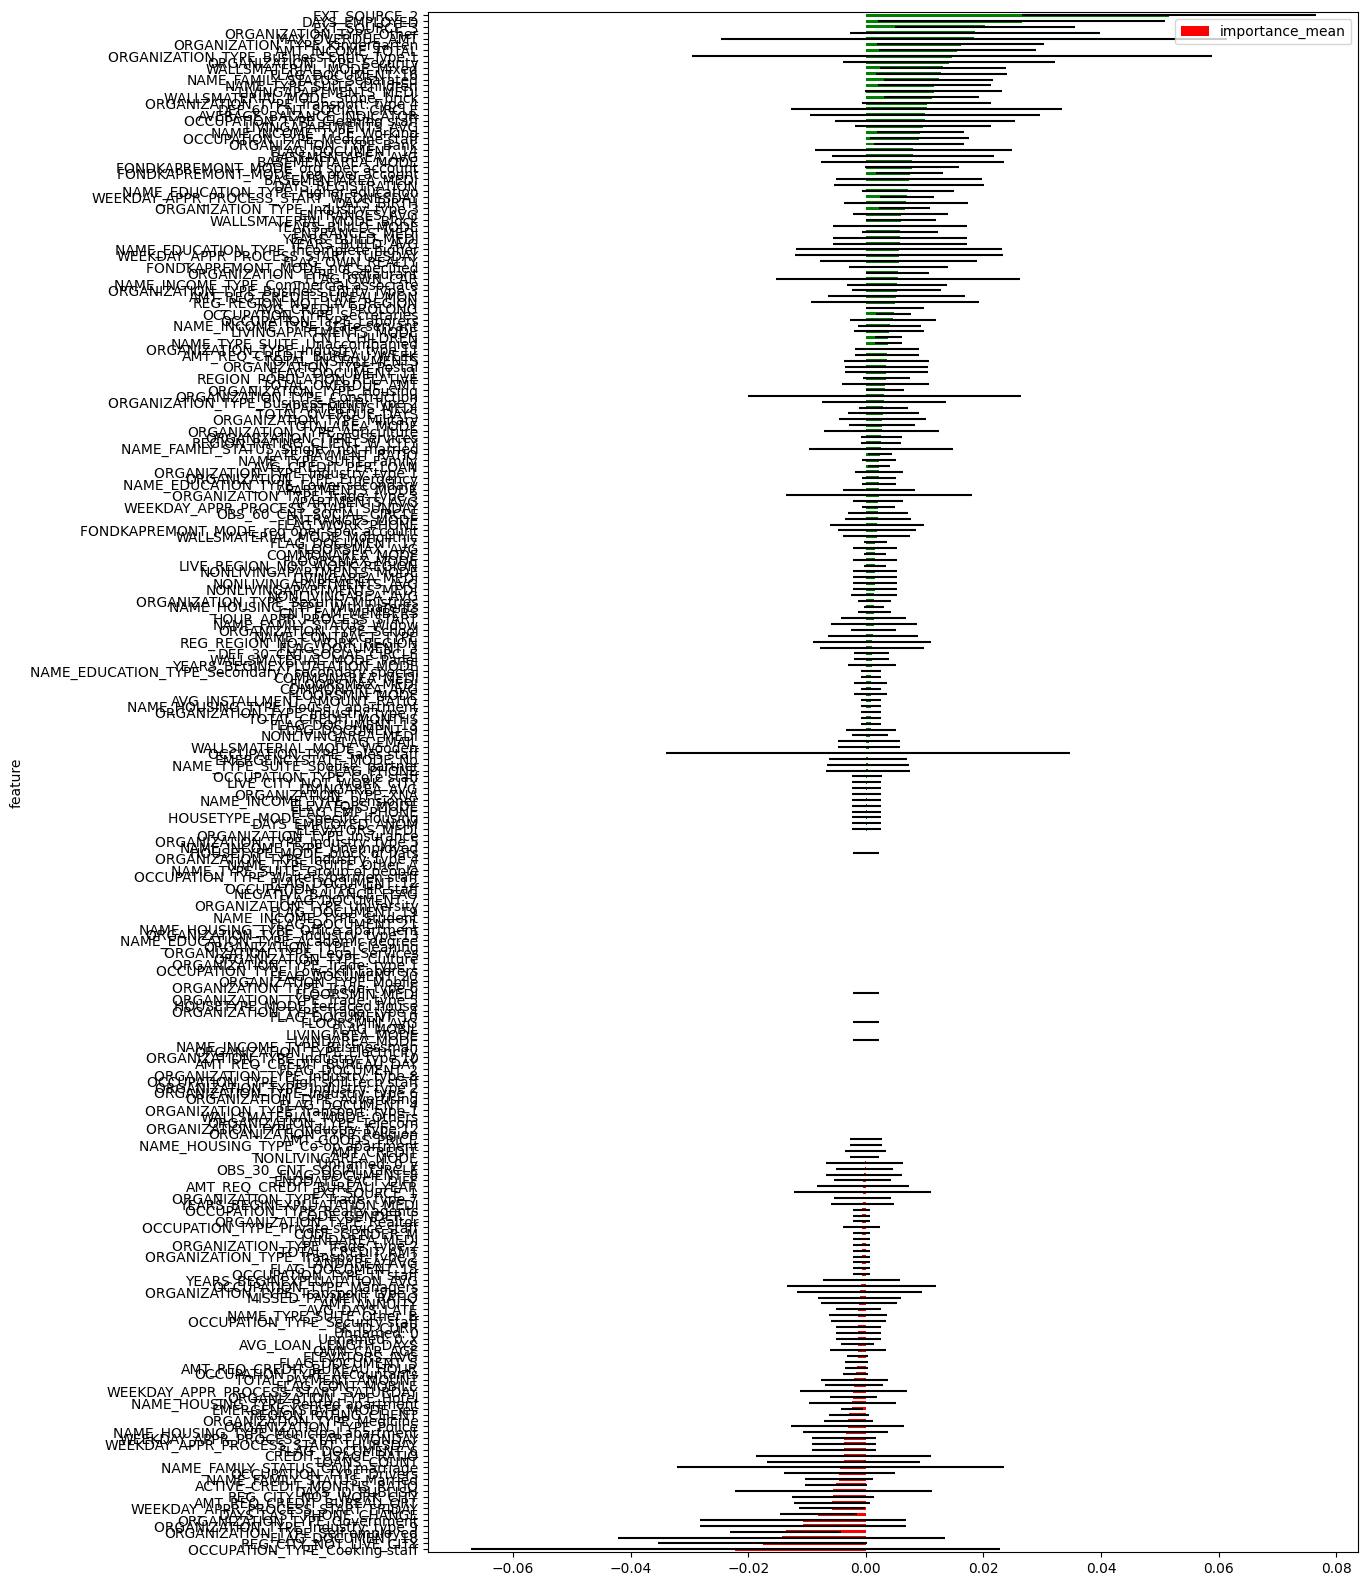

In [3]:
# define a pipeline with SimpleImputer, StandardScaler, and RidgeClassifier
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RidgeClassifier(alpha=1.0, tol=0.01, solver='saga', random_state=50))
])

sample_df = train_merged_df.sample(frac=0.001, random_state=0)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dataset = Dataset(df=sample_df, target="TARGET", features=[col for col in train_merged_df.columns if col != "TARGET"])
lofo_imp = LOFOImportance(dataset, cv=stratified_kfold, scoring="roc_auc", model=pipeline)
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 20))

In [8]:
good_features = importance_df[importance_df.importance_mean > 0].feature.tolist()

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RidgeClassifier(alpha=1.0, tol=0.001, solver='saga', random_state=50))
])

pipeline.fit(train_merged_df[good_features], TARGET)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 RidgeClassifier(random_state=50, solver='saga', tol=0.001))])

In [9]:
# define the features for the test data
X_test = test_merged_df[good_features]
# impute missing values in the test data using the imputer in the pipeline
X_test = pipeline.named_steps['imputer'].transform(X_test)

# transform the test data using the scaler in the pipeline
X_test = pipeline.named_steps['scaler'].transform(X_test)

# make predictions using the classifier in the pipeline
y_pred = pipeline.named_steps['clf']._predict_proba_lr(X_test)

In [49]:
df = pd.DataFrame({'SK_ID_CURR': test_merged_df['SK_ID_CURR'], 'TARGET': y_pred[:, 1]})
df.to_csv('ridge with LOFO.csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/ridge with LOFO.csv" -m "ridge with LOFO tol 0.001"

100% 1.23M/1.23M [00:01<00:00, 866kB/s] 
Successfully submitted to Home Credit Default Risk

#### Results
Private Score 0.67334
Public Score 0.67363

Leaving out features even if they seem to hurt the performance seem to mess everything up! (Lowest score ever!)

### Hyperparameter optimization

In [50]:
!pip install optuna
import optuna

from sklearn.model_selection import StratifiedKFold, cross_val_score

# define the study objective
def objective(trial):

    # define the hyperparameters to be optimized
    alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)

    # define the pipeline
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RidgeClassifier(alpha=alpha, tol=0.001, solver='saga', random_state=50))
    ])

    # define the validation scheme
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # compute the cross-validation score
    score = np.mean(cross_val_score(pipeline, train_merged_df[good_features], TARGET, cv=kfold, scoring="roc_auc"))

    # report the score for this trial
    return score

# run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# print the best hyperparameters and ROC AUC score
print(f"Best ROC AUC = {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


[I 2023-06-25 16:03:30,386] A new study created in memory with name: no-name-c7f0f150-a569-4f31-b683-ad1af9ec074a
<ipython-input-50-564bf5affb4b>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)
[I 2023-06-25 16:04:29,094] Trial 0 finished with value: 0.692262954439506 and parameters: {'alpha': 0.09531954999043747}. Best is trial 0 with value: 0.692262954439506.
<ipython-input-50-564bf5affb4b>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)
[I 2023-06-25 16:05:30,750] Trial 1 finished with value: 0.6922629601393652 and parameters: {'alpha': 8.850560764540649e-0

Best ROC AUC = 0.6923
Best Parameters:
    alpha: 1.0048828586712337


In [10]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RidgeClassifier(alpha=1.0048828586712337, tol=0.001, solver='saga', random_state=50))
])

pipeline.fit(train_merged_df[good_features], TARGET)
# define the features for the test data
X_test = test_merged_df[good_features]
# impute missing values in the test data using the imputer in the pipeline
X_test = pipeline.named_steps['imputer'].transform(X_test)

# transform the test data using the scaler in the pipeline
X_test = pipeline.named_steps['scaler'].transform(X_test)

# make predictions using the classifier in the pipeline
y_pred = pipeline.named_steps['clf']._predict_proba_lr(X_test)

In [12]:
df = pd.DataFrame({'SK_ID_CURR': test_merged_df['SK_ID_CURR'], 'TARGET': y_pred[:, 1]})
df.to_csv('ridge LOFO Alpha Tuning.csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/ridge LOFO Alpha Tuning.csv" -m "ridge with LOFO Alpha Tuning tol 0.001"

100% 1.23M/1.23M [00:01<00:00, 1.26MB/s]
Successfully submitted to Home Credit Default Risk

##### Results 1
Private Score 0.71818 Public Score 0.72234

I will also optimize for the larger feature set

In [54]:
import optuna

from sklearn.model_selection import StratifiedKFold, cross_val_score

# define the study objective
def objective(trial):

    # define the hyperparameters to be optimized
    alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)

    # define the pipeline
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RidgeClassifier(alpha=alpha, tol=0.01, solver='saga', random_state=50))
    ])

    # define the validation scheme
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # compute the cross-validation score
    score = np.mean(cross_val_score(pipeline, train_merged_df, TARGET, cv=kfold, scoring="roc_auc"))

    # report the score for this trial
    return score

# run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# print the best hyperparameters and ROC AUC score
print(f"Best ROC AUC = {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2023-06-25 16:19:12,096] A new study created in memory with name: no-name-626a66e8-273d-44cc-8721-05dc34dff124
<ipython-input-54-1fe3231831ce>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)
[I 2023-06-25 16:22:38,250] Trial 0 finished with value: 0.7517464454941389 and parameters: {'alpha': 1.3101081066846416}. Best is trial 0 with value: 0.7517464454941389.
<ipython-input-54-1fe3231831ce>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)
[I 2023-06-25 16:25:59,351] Trial 1 finished with value: 0.7517464390816523 and parameters: {'alpha': 1.2568861715777326e-0

Best ROC AUC = 0.7517
Best Parameters:
    alpha: 1.3101081066846416


In [6]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RidgeClassifier(alpha=1.3101081066846416, tol=0.01, solver='saga', random_state=50))
])

pipeline.fit(train_merged_df, TARGET)
# define the features for the test data
X_test = test_merged_df
# impute missing values in the test data using the imputer in the pipeline
X_test = pipeline.named_steps['imputer'].transform(X_test)

# transform the test data using the scaler in the pipeline
X_test = pipeline.named_steps['scaler'].transform(X_test)

# make predictions using the classifier in the pipeline
y_pred = pipeline.named_steps['clf']._predict_proba_lr(X_test)

In [8]:
df = pd.DataFrame({'SK_ID_CURR': test_merged_df['SK_ID_CURR'], 'TARGET': y_pred[:, 1]})
df.to_csv('ridge with Hyperparameter Tuned No LOFO.csv', index=False)
!kaggle competitions submit -c home-credit-default-risk -f "/content/ridge with Hyperparameter Tuned No LOFO.csv" -m "ridge ridge Hyperparameter Tuned NO LOFO t 0.01"

100% 1.23M/1.23M [00:01<00:00, 942kB/s]
Successfully submitted to Home Credit Default Risk

##### Results 1
Private Score
0.73952
Public Score
0.74678

### Conclusion

It has been a long weekend in which I have come to realize the importance of feature engineering. No matter how hard you try to optimize your parameters or select your features for this dataset the way to win seems to be in feature enigneering.

It has been a pleasure to try to develop a model, I did not have the chance to do this sort of stuff for a while! I hope this has been satisfactory.

Thank you for considering my application.

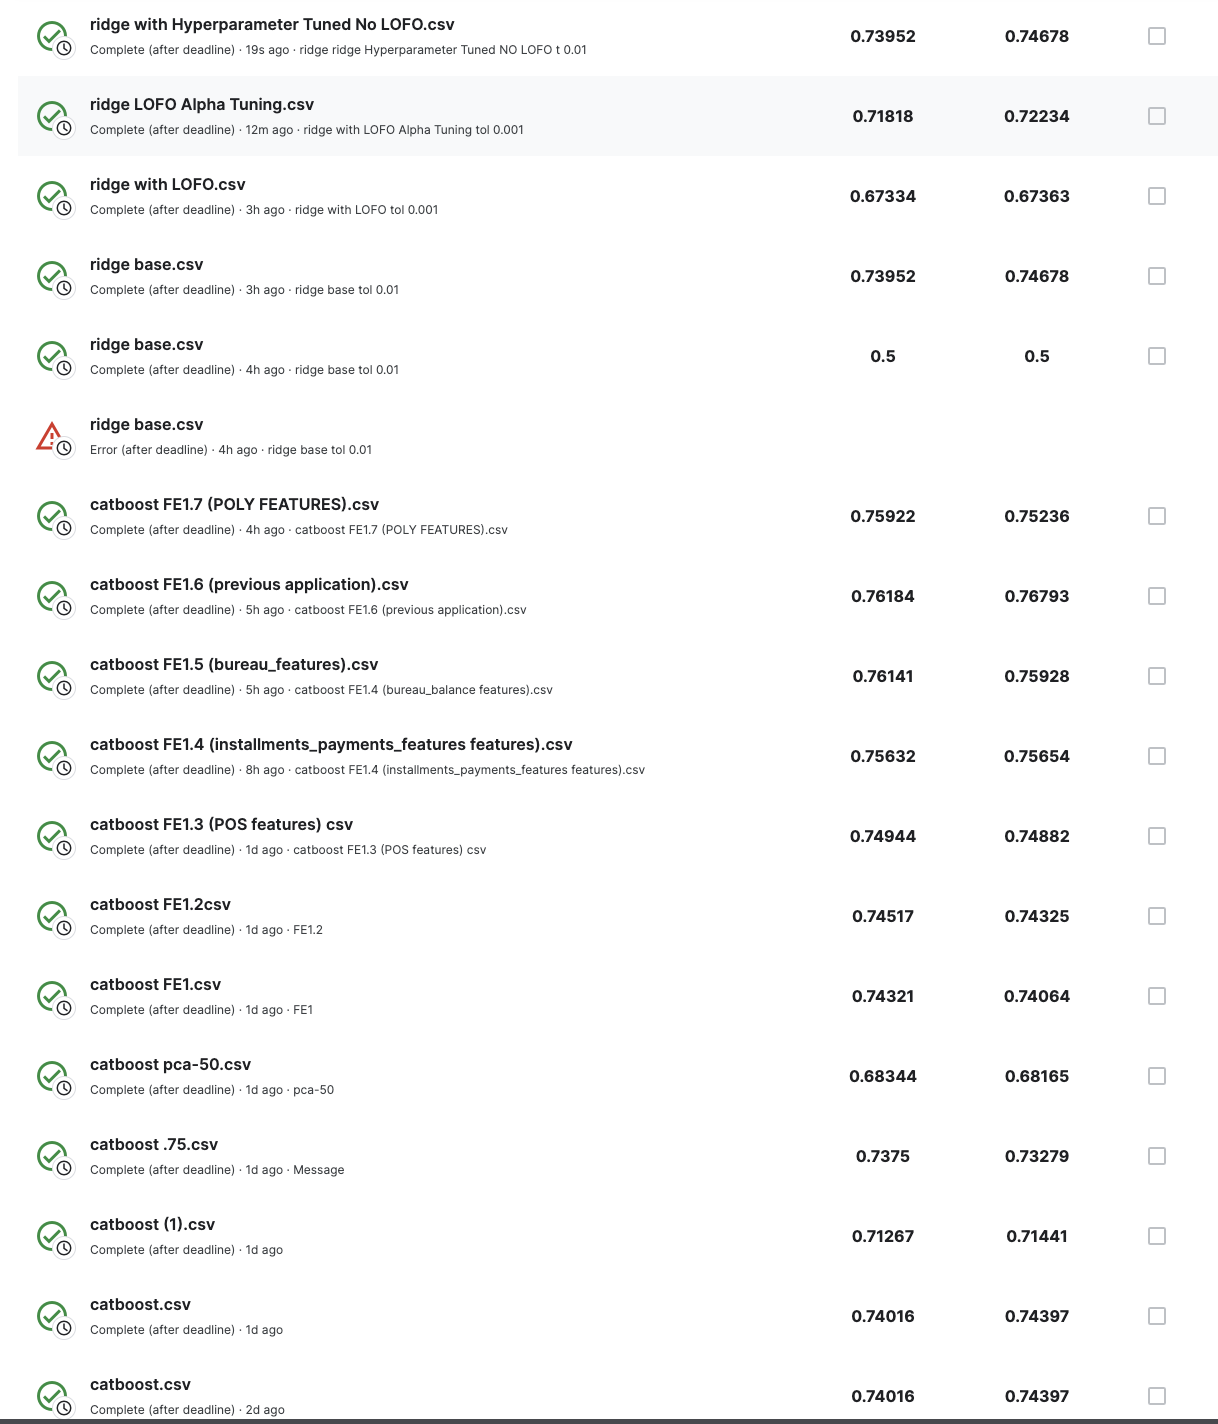